### Visualize HeatMap Activations in the pretrained AlexNet of Pytorch

+ This notebook shows how to use PyTorch (and TorchVision) to visualize heatmap activations   


+ The code shows how to connect the model to the GPU, and how to ensire that the data is also loaded into the GPU


In [1]:
# import APIS for basioc img processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# inport Torch APIs 
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F


In [3]:
def visualize_heatmap(image_path, target_class=None):
    """
    Visualizes a heatmap for an image using a pretrained AlexNet.

    Args:
        image_path (str): Path to the input image.
        target_class (int, optional): The target class for heatmap generation.
          If None, the predicted class will be used.
    """

    # get the model 
    alexnet = models.alexnet(pretrained=True)
    alexnet.eval()

    """transform image into a tensor that PyTorch can use. 
    1. Resize img to 256x256 pixels
    2. Crop img center to 224x224
    3. Convert img to a PyTorch tensor
    4. Normalize tensor using ImageNet values for mean and std in each channel (RGB)
    """
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # load img 
    img = Image.open(image_path).convert("RGB")

    # apply transformations as defined above. 
    img_tensor = transform(img).unsqueeze(0)

    # Ask PyTorch to keep track of the tensor gradients,
    # which we need for backpropagation
    img_tensor.requires_grad_()

    # 
    # Determine Target Class
    #

    # Gradient Calculations and Hooks
    target_layer = alexnet.features[10] # get the last conv layer in AlexNet features module
    gradients = None

    # setup a backward hook to capture the gradients of the target layer
    def gradient_hook(grad):
        nonlocal gradients
        gradients = grad

    target_layer.register_backward_hook(lambda module, grad_input, grad_output: gradient_hook(grad_output[0]))

    activations = None
    def activation_hook(module, input, output):
        nonlocal activations
        activations = output

    # setup a forward loop to capture the activations of the target layer
    target_layer.register_forward_hook(activation_hook)

    # pass the img_tensor through alexnet and obtain the output classes.
    # apply softmax to get the class probabilities
    output = alexnet(img_tensor)
    output = F.softmax(output, dim=1)

    if target_class is None:
        _, predicted_class = torch.max(output, 1)
        target_class = predicted_class.item()

    target_output = output[0, target_class]

    # perform backpropagation to calculate the gradients
    alexnet.zero_grad()
    target_output.backward()

    ### GENERATE HEATMAP

    #calculate the av gradients across the (w,h) dimensions
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # detach activations from computation graph
    activations = activations.detach()[0]

    for i in range(256):
        activations[i] *= pooled_gradients[i]

    # weight the activations by the corresponding pooled gradients
    # Do the ave weighted activations to create the heatmap
    heatmap = torch.mean(activations, dim=0).cpu().numpy()

    heatmap = np.maximum(heatmap, 0) # Apply RELU !!!
    heatmap /= np.max(heatmap)

    #load orig img 
    img_cv = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap onto the original image
    superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    plt.imshow(superimposed_img[:,:,::-1])
    plt.show()

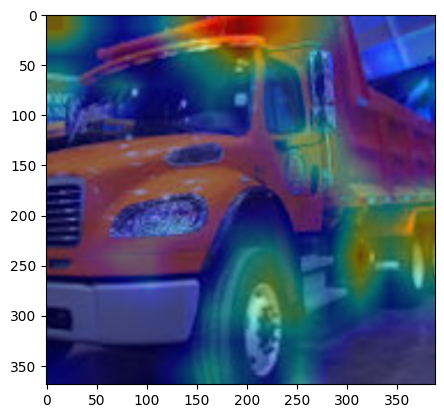

In [13]:


image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/cat_img_from_amazon_s3.jpg"
image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/dog.582.jpg"
image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/cat.444.jpg"
image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/baby_794.jpg"
image_path = "/drv3/hm3/Data/ImgData/BruntonBookCh01_Images/JasiuBaby.jpg"
image_path = "/home/juan/Pictures/Truck.png"



#image_path = "/drv3/hm3/Data/ImgData/Oxford_iiit_pets/CeciliaMaya.png"



visualize_heatmap(image_path)
#visualize_heatmap(image_path, target_class=282) #example of using a specific class.
